# Przykład klasyfikacji wykonanej za pomocą regresji logistycznej - eliminacja współliniowości zmiennych niezależnych za pomocą VIF.

Rozważania teoretyczne na temat znaczenia (szkodliwości) wspołiniowości zmiennych niezależnych (multicollinearity) zostały wyjaśnione w poprzedniej części.
http://sigmaquality.pl/machine-learning/seaborn-machine-learning/multicollinearity-w-regresji-logistycznej-vif-pl202001081905/

Tym razem będziemy analizowali zagadnienie zanieczyśczenia miasta.
Źródło danych można znaleźć tutaj: 


In [1]:
import pandas as pd
df = pd.read_csv('c:/TF/AirQ_filled.csv')
df.head(3)

,Unnamed: 0,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502


Na początku sprawdzimy kompletność danych oraz ich format.   

In [2]:
del df['Unnamed: 0']
df.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [3]:
df.dtypes

Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

Dane są kompletne i mają włąściwy format do prowadzenia daszej analizy.

### Zadanie

Naszym zadaniem jest podział na trzy klasy zanieczyszczenia oznaczonego jako PT08.S5(03). Następnie musimy zbudować model klasyfikacji logistycznej oparty na pozostałych zmiennych w postaci poziomów zanieczyszczeń.

Korelacja zmiennych niezależnych ze zmienną zależną.

In [4]:
CORREL = df.corr()

import seaborn as sns
sns.heatmap(CORREL, annot=True, cbar=False, cmap="coolwarm")

Powyższa macierz wskazuje, że istnieje współliniowość, która negatywnie wpłynie na poziom klasyfikacji. Nie zważając na to kontynujemy realizację naszego zadania. Poniżej przeprowadziłem analizę korelacji zmiennej zależnej: 'PT08.S5(O3)' ze zmiennymi niezależnymi. W wiekszości występuje wysoki poziom korelacji co jest zjawiskiem pozytywnym.

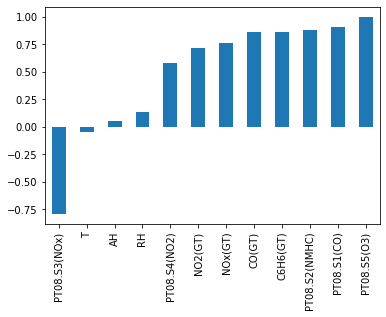

In [5]:
CORREL2 = df.corr().sort_values('PT08.S5(O3)')
CORREL2['PT08.S5(O3)'].plot(kind='bar')

In [6]:
df['Categores_PT08.S5(O3)'] = pd.qcut(df['PT08.S5(O3)'],2)
df['Categores_PT08.S5(O3)'].value_counts().to_frame()

,Categores_PT08.S5(O3)
"(220.999, 964.0]",4683
"(964.0, 2523.0]",4674


Badana kategoria PT08.S5(O3) została podzielona na równe przedziały. Mniejsza o to czy ten podział jest uzasadniony chemicznie. Najważniejsze że teraz możemy utworzyć model klasyfikacji oparty na regresji logistycznej. 
Równy podział zbiorów oddala nas od negatywnego zjawiska niezbilansowania zbiorów i koniczności tworzenia oversampling. Dzisiaj nie to jest najważniejsze lecz przećwiczenie radzenia sobie ze zjawiskiej multicollinearity.

Zbudjemy model klasyfikacji tak jakby nie dotyczył nas problem multicollinearity.

##### Wskazujemy zmienne niezależne:

In [7]:
KOT = df[['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 
       'T', 'RH', 'AH','Categores_PT08.S5(O3)']]
KOT.columns = ['CO_GT', 'PT08_S1_CO', 'C6H6_GT', 'PT08_S2_NMHC',
       'NOx_GT', 'PT08_S3_NOx', 'NO2_GT', 'PT08_S4_NO2', 
       'T', 'RH', 'AH','Categores_PT08_S5_O3']

Przekształcamy zmienną zależną: Categores_PT08.S5(O3) na zmienną ciągłą.

In [8]:
KOT['Categores_PT08_S5_O3'] = KOT['Categores_PT08_S5_O3'].astype(str)
KOT['Categores_PT08_S5_O3'].dtypes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


dtype('O')

In [9]:
from sklearn.model_selection import train_test_split 


y = KOT['Categores_PT08_S5_O3']
X = KOT.drop('Categores_PT08_S5_O3', axis=1)


Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.33, stratify = y, random_state = 148)

In [10]:
KOT.dtypes

CO_GT                   float64
PT08_S1_CO              float64
C6H6_GT                 float64
PT08_S2_NMHC            float64
NOx_GT                  float64
PT08_S3_NOx             float64
NO2_GT                  float64
PT08_S4_NO2             float64
T                       float64
RH                      float64
AH                      float64
Categores_PT08_S5_O3     object
dtype: object

In [11]:
print ('Zbiór X treningowy: ',Xtrain.shape)
print ('Zbiór X testowy:    ', Xtest.shape)
print ('Zbiór y treningowy: ', ytrain.shape)
print ('Zbiór y testowy:    ', ytest.shape)

Zbiór X treningowy:  (6269, 11)
Zbiór X testowy:     (3088, 11)
Zbiór y treningowy:  (6269,)
Zbiór y testowy:     (3088,)


In [12]:
import numpy as np
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Parameteres = {'C': np.power(10.0, np.arange(-3, 3))}
LR = LogisticRegression(warm_start = True)
LR_Grid = GridSearchCV(LR, param_grid = Parameteres, scoring = 'roc_auc', n_jobs = 5, cv=2)

LR_Grid.fit(Xtrain, ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=True),
             iid='warn', n_jobs=5,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

#### Ocena modelu regresji logistycznej bez redukcji zjawiska multicollinearity

In [13]:
ypred = LR_Grid.predict(Xtest)

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

co_matrix = metrics.confusion_matrix(ytest, ypred)
co_matrix

array([[1414,  131],
       [ 176, 1367]], dtype=int64)

In [14]:
print(classification_report(ytest, ypred))

                  precision    recall  f1-score   support

(220.999, 964.0]       0.89      0.92      0.90      1545
 (964.0, 2523.0]       0.91      0.89      0.90      1543

        accuracy                           0.90      3088
       macro avg       0.90      0.90      0.90      3088
    weighted avg       0.90      0.90      0.90      3088



Model wykazuje się doskonałymi zdolnościmi prognostycznymi w klasyfikacji zanieczyszczenia. Nie oznacza to jednak, że wszystko jest doskonale. Wśród zmiennych opisujących występuje wysoka multicollinearity. Jest to niekorzystne zjawiski, które teraz wyelinimujemy. 

## Eliniminacja zjawiska multicollinearity

### <span style = "color: darkgreen"> Variance Inflation Factor (VIF)</span>

Variance Inflation Factor (VIF) to miara multicollinearity między zmiennymi predykcyjnymi w regresji wielokrotnej. Określa ilościowo nasilenie multicollinearity w zwykłej analizie regresji metodą najmniejszych kwadratów. Zapewnia wskaźnik, który mierzy, o ile wariancja (kwadrat odchylenia standardowego oszacowania) szacowanego współczynnika regresji jest zwiększona z powodu kolinearności. 

Kroki wdrażania VIF
1. Uruchom regresję wieloraką. 
2. Oblicz współczynniki VIF.
3. Sprawdź współczynniki dla każdej zmiennej predykcyjnej, jeśli VIF wynosi między 5-10, prawdopodobnie występuje multicollinearity i powinieneś rozważyć usunięcie tej zmiennej.

Czyli przed rozpoczęciem pracy nad modelem regresji logistycznej należy utworzyć model regresji wielorakiej i przez VIF wyselekcjonować, wybrać dane do modelu regresji logistycznej.

Jak wspominają tutaj: https://www.ibm.com/support/pages/multicollinearity-diagnostics-logistic-regression-nomreg-or-plum
> Procedury regresji dla zmiennych zależnych kategorycznie nie mają diagnostyki kolinearności. W tym celu można jednak użyć procedury regresji liniowej. Statystyka kolinearności w regresji dotyczy relacji między predyktorami, ignorując zmienną zależną. Możesz więc uruchomić REGRESSION z tą samą listą predyktorów i zmiennej zależnej, jakiej chcesz użyć w REGRESJI LOGISTYCZNEJ (na przykład) i zażądać diagnostyki kolinearności. Uruchom regresję logistyczną, aby uzyskać właściwe współczynniki, przewidywane prawdopodobieństwa itp. Po podjęciu niezbędnych decyzji (porzucenie predyktorów itp.) Wynikających z analizy kolinearności.


In [16]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

lm = smf.ols(formula = 'Categores_PT08_S5_O3 ~ CO_GT+PT08_S1_CO+C6H6_GT+PT08_S2_NMHC+NOx_GT+PT08_S3_NOx+NO2_GT+PT08_S4_NO2+T+RH+AH', data = KOT).fit()
y, X = dmatrices('Categores_PT08_S5_O3 ~ CO_GT+PT08_S1_CO+C6H6_GT+PT08_S2_NMHC+NOx_GT+PT08_S3_NOx+NO2_GT+PT08_S4_NO2+T+RH+AH', data = KOT, return_type = "dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

[648.230997747899, 11.43831319456862, 7.939972023928728, 46.44356640618427, 66.47134191824114, 5.220873142678388, 5.43267527445646, 3.714154563031008, 14.52279194616348, 14.359778937836424, 8.176237173633366, 10.619321015188527]


In [17]:
vif  =  np.round(vif, decimals=2) 
vif = list(map(float, vif))
name = list(X)

s1=pd.Series(name,name='name')
s2=pd.Series( vif,name='vif')

RFE_list = pd.concat([s1,s2], axis=1)

RFE_list

,name,vif
0,Intercept,648.23
1,CO_GT,11.44
2,PT08_S1_CO,7.94
3,C6H6_GT,46.44
4,PT08_S2_NMHC,66.47
5,NOx_GT,5.22
6,PT08_S3_NOx,5.43
7,NO2_GT,3.71
8,PT08_S4_NO2,14.52
9,T,14.36


Interpretacja: wynik w postaci wektora reprezentuje zmienną w określonej kolejności jak w modelu. W zaleceniu VIF wskazano, że jeśli współczynnik przypisany do zmiennej jest większy niż 5, zmienna ta jest wysoce skorelowana z innymi zmiennymi i powinna zostać wyeliminowana z modelu.

Test wykazał, że zmienne: _density_ oraz _factorA_ powinny zostać usunięta z modelu.
jeszcze raz oglądamy macierz korelacji

### Jeszcze raz tworzymy macierz korelacji vif i sprawdzamy zmienne po wyeliminowaniu: 
 - C6H6_GT
 - PT08_S2_NMHC
 - PT08_S4_NO2
 
 Eliminuje też zmienne gdzie korelacja ze zmienną zależną było bardzo małe a zmienne miały VIF powyżej 5:
 
 - T
 - RH
 - AH
 

In [18]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

lm = smf.ols(formula = 'Categores_PT08_S5_O3 ~ CO_GT+PT08_S1_CO+NOx_GT+PT08_S3_NOx+NO2_GT', data = KOT).fit()
y, X = dmatrices('Categores_PT08_S5_O3 ~ CO_GT+PT08_S1_CO+NOx_GT+PT08_S3_NOx+NO2_GT', data = KOT, return_type = "dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

[200.1579775895654, 5.895905610386816, 5.807909737315139, 3.1029777937073924, 2.7926706710126528, 2.4675790616762594]


In [19]:
vif  =  np.round(vif, decimals=2) 
vif = list(map(float, vif))
name = list(X)

s1=pd.Series(name,name='name')
s2=pd.Series( vif,name='vif')

RFE_list = pd.concat([s1,s2], axis=1)

RFE_list

,name,vif
0,Intercept,200.16
1,CO_GT,5.90
2,PT08_S1_CO,5.81
3,NOx_GT,3.10
4,PT08_S3_NOx,2.79
5,NO2_GT,2.47


Teraz zmienne, pomimo wysokich stanów przekraczających 5, to są: CO_GT i PT08_S1_CO są akceptowane w zakresie poziomu multicollinearity. Tworzę nowy model klasyfikacji na okrojonym zbiorze zmienych opisujących.

In [20]:
KOT2 = KOT[['Categores_PT08_S5_O3', 'CO_GT', 'PT08_S1_CO','NOx_GT', 'PT08_S3_NOx', 'NO2_GT']]

KOT2.sample(3)

,Categores_PT08_S5_O3,CO_GT,PT08_S1_CO,NOx_GT,PT08_S3_NOx,NO2_GT
790,"(220.999, 964.0]",1.4,1035.0,96.0,1222.0,82.0
2484,"(220.999, 964.0]",0.9,890.0,93.0,922.0,67.0
4306,"(220.999, 964.0]",0.5,828.0,72.0,1281.0,48.0


### Budujemy model klasyfikacji po VIF

In [22]:
#from sklearn.model_selection import train_test_split 


y = KOT2['Categores_PT08_S5_O3']
X = KOT2.drop('Categores_PT08_S5_O3', axis=1)


Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.33, stratify = y, random_state = 148)

In [23]:
#import numpy as np
#from sklearn import model_selection
#from sklearn.pipeline import make_pipeline
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV

Parameteres = {'C': np.power(10.0, np.arange(-3, 3))}
LR = LogisticRegression(warm_start = True)
LR_VIF = GridSearchCV(LR, param_grid = Parameteres, scoring = 'roc_auc', n_jobs = 5, cv=2)

LR_VIF.fit(Xtrain, ytrain)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=True),
             iid='warn', n_jobs=5,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

#### Ocena modelu regresji logistycznej bez redukcji zjawiska multicollinearity

In [24]:
ypred = LR_VIF.predict(Xtest)

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

co_matrix = metrics.confusion_matrix(ytest, ypred)
co_matrix

array([[1387,  158],
       [ 182, 1361]], dtype=int64)

In [26]:
print(classification_report(ytest, ypred))

                  precision    recall  f1-score   support

(220.999, 964.0]       0.88      0.90      0.89      1545
 (964.0, 2523.0]       0.90      0.88      0.89      1543

        accuracy                           0.89      3088
       macro avg       0.89      0.89      0.89      3088
    weighted avg       0.89      0.89      0.89      3088



Nowy model zbudowany na pięciu niezwiązanych przez multicollinearity jest nieznacznie gorszy (na poziomie 1-2%) w stosunku do modelu zbudowanego na silnie wewnętrzernie współliniowych jedenastu zmiennych. Mała ilość zmiennych niezależnych w stosunku do wysokiej dokładności pokaznych wskaźnikami:  precision i recall oznacza jakościową poprawę sprawności klasyfikacji modelu regresji logistycznej.